##  <font color='red'> Model 3: Single word speech recognition using Attention Recurrent Neural Network and MFCC Feature Extraction </font>

### Import Libraries

In [38]:
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import signal 
from scipy.io import wavfile 
import os 
import IPython.display as ipd
import math as mt 
import librosa 
from librosa.display import waveplot
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Permute, Dropout, Flatten, Conv2D, BatchNormalization, Input, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

Populating the interactive namespace from numpy and matplotlib


//anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Import the data

In [39]:
train_audio_path = "audio_data/Audio_8hz"

In [40]:
labels=os.listdir(train_audio_path)
labels

['backward',
 'happy',
 'silence',
 'no',
 'nine',
 'stop',
 'zero',
 'up',
 'down',
 'yes',
 'on',
 'forward',
 'off']

In [41]:
labels_to_consider = [
 'backward',
 'down',
 'forward',
 'happy',
 'no',
 'on',
 'off',
 'silence',
 'stop',
 'up',
 'yes']

### Check the baseline using majority classification rule:
#### The majority class in this model is "unknown" with the 19.2% of audio files. So, the baseline of this model is 19.2%

In [42]:
count_unknown = 0
train_audio_path = 'audio_data/Audio_8hz/'
labels=os.listdir(train_audio_path)
total_count = 0
for label in labels:
    total_count = total_count + len(os.listdir(train_audio_path+label))
for label in labels:
    if label == 'zero' or label == 'nine':
        count = len(os.listdir(train_audio_path+label))
        count_unknown = count_unknown + count
    else:
        count = len(os.listdir(train_audio_path+label))
        print(label+'\t'+str(round(count/total_count*100,1))+'%')
print('unknown' +'\t'+str(round(count_unknown/total_count*100,1))+'%')

backward	4.0%
happy	4.9%
silence	2.7%
no	9.5%
stop	9.3%
up	8.9%
down	9.4%
yes	9.7%
on	9.2%
forward	4.1%
off	9.0%
unknown	19.2%


### Feature extraction of sample audio file:

In [43]:
file_path = "audio_data/Audio_8hz/down/0a2b400e_nohash_3.wav"
max_pad_len=16
audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', sr = 8000)
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
pad_width = max_pad_len - mfccs.shape[1]
mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
print(mfccs.shape)

(40, 16)


### Define a function for feature extraction of all audio files

In [45]:

max_pad_len = 16
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, res_type='kaiser_fast', sr = 8000)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 

    return mfccs


### Save the extracted features in a pandas data frame

In [46]:
features = []
all_label = []

for label in labels:
    count = 0
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        data = extract_features(train_audio_path + '/'+ label + '/' + wav)
        if label in labels_to_consider:
            features.append([data, label])
            all_label.append(label)
        else:
            features.append([data, 'unknown'])
            all_label.append('unknown')

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

#### Convert the output labels to integer encoded:

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

### Final list of classes

In [48]:
classes

['backward',
 'down',
 'forward',
 'happy',
 'no',
 'off',
 'on',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes']

### Convert features and corresponding classification labels into numpy arrays

In [49]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


### Split the training and validation data

In [50]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 77)


In [51]:
x_train.shape

(33280, 40, 16)

### Create Model

In [16]:

    
num_rows = 40
num_columns = 16
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
inputs = L.Input((40,16,1), name='input')

x = L.Conv2D(30, (5, 1), activation='relu', padding='same')(inputs)
x = L.BatchNormalization()(x)
x = Dropout(0.25)(x)

x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)
x = Dropout(0.25)(x)

x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)
x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)  
x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x) 

xFirst = L.Lambda(lambda q: q[:, -1])(x) 
query = L.Dense(128)(xFirst)

# dot product attention
attScores = L.Dot(axes=[1, 2])([query, x])
attScores = L.Softmax(name='attSoftmax')(attScores)  

attVector = L.Dot(axes=[1, 1])([attScores, x])

x = L.Dense(64, activation='relu')(attVector)
x = L.Dense(32)(x)

output = L.Dense(num_labels, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 40, 16, 30)   180         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 40, 16, 30)   120         conv2d_4[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 40, 16, 30)   0           batch_normalization_4[0][0]      
______________________________________________________________________________________________

### Compile Model

In [17]:
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

### Set early stopping on minimum validation loss

In [18]:

import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [21]:
earlystopper = EarlyStopping(monitor='val_loss', patience=10,verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=30, verbose=1,callbacks=[earlystopper, lrate])

Train on 33280 samples, validate on 8321 samples
Changing learning rate to 0.001
Epoch 1/30
33280/33280 [==============================] - 246s 7ms/sample - loss: 1.1578 - accuracy: 0.6021 - val_loss: 0.8956 - val_accuracy: 0.6991
Changing learning rate to 0.001
Epoch 2/30
33280/33280 [==============================] - 252s 8ms/sample - loss: 0.9335 - accuracy: 0.6793 - val_loss: 0.7436 - val_accuracy: 0.7480
Changing learning rate to 0.001
Epoch 3/30
33280/33280 [==============================] - 260s 8ms/sample - loss: 0.8218 - accuracy: 0.7197 - val_loss: 0.6701 - val_accuracy: 0.7735
Changing learning rate to 0.001
Epoch 4/30
33280/33280 [==============================] - 247s 7ms/sample - loss: 0.7462 - accuracy: 0.7452 - val_loss: 0.6160 - val_accuracy: 0.7957
Changing learning rate to 0.001
Epoch 5/30
33280/33280 [==============================] - 250s 8ms/sample - loss: 0.6916 - accuracy: 0.7642 - val_loss: 0.6010 - val_accuracy: 0.7941
Changing learning rate to 0.001
Epoch 6/3

### Save the model

In [33]:
model.save('attRNN_model.h5')

### Check the maximum validation and training accuray

In [23]:
# Evaluating the model on the training and testing set
print("Maximum training accuracy: ", max(history.history['accuracy']))
print("Maximum validation accuracy: ", max(history.history['val_accuracy']))

Maximum training accuracy:  0.89903843
Maximum validation accuracy:  0.8631174


### Plot results

#### Visualize validation and training loss

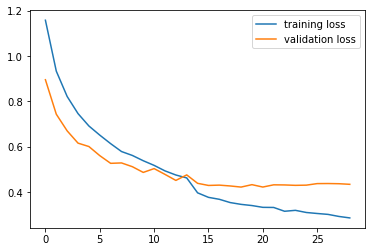

In [37]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='training loss')
pyplot.plot(history.history['val_loss'], label='validation loss')
pyplot.legend()
pyplot.show()

### Visualize training and validation accuracy

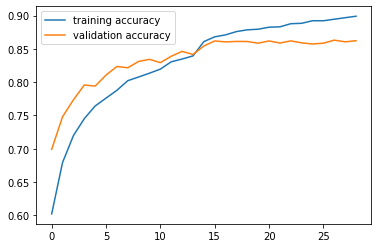

In [36]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='training accuracy')
pyplot.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

### Predictions

In [26]:
def predict(audio):
    prob=model.predict(audio.reshape(1,40,16,1))
    index=np.argmax(prob[0])
    return classes[index]


import random
for i in range(10):
    index=random.randint(0,len(x_test)-1)
    samples=x_test[index].ravel()
    print("\nAudio:",classes[np.argmax(y_test[index])])
    print("Text:",predict(samples))


Audio: happy
Text: happy

Audio: stop
Text: stop

Audio: unknown
Text: unknown

Audio: down
Text: down

Audio: no
Text: no

Audio: backward
Text: backward

Audio: up
Text: up

Audio: happy
Text: happy

Audio: yes
Text: yes

Audio: unknown
Text: unknown


### Generate Confusion Matrix

In [27]:
y_pred = model.predict(x_test)

In [28]:
y_pred_again = []
for i in range(len(y_pred)):
    r = np.zeros(12)
    r[np.argmax(y_pred[i])] = 1
    y_pred_again.append(r)

In [29]:
yyyyy = np.array(y_pred_again)

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), yyyyy.argmax(axis=1))

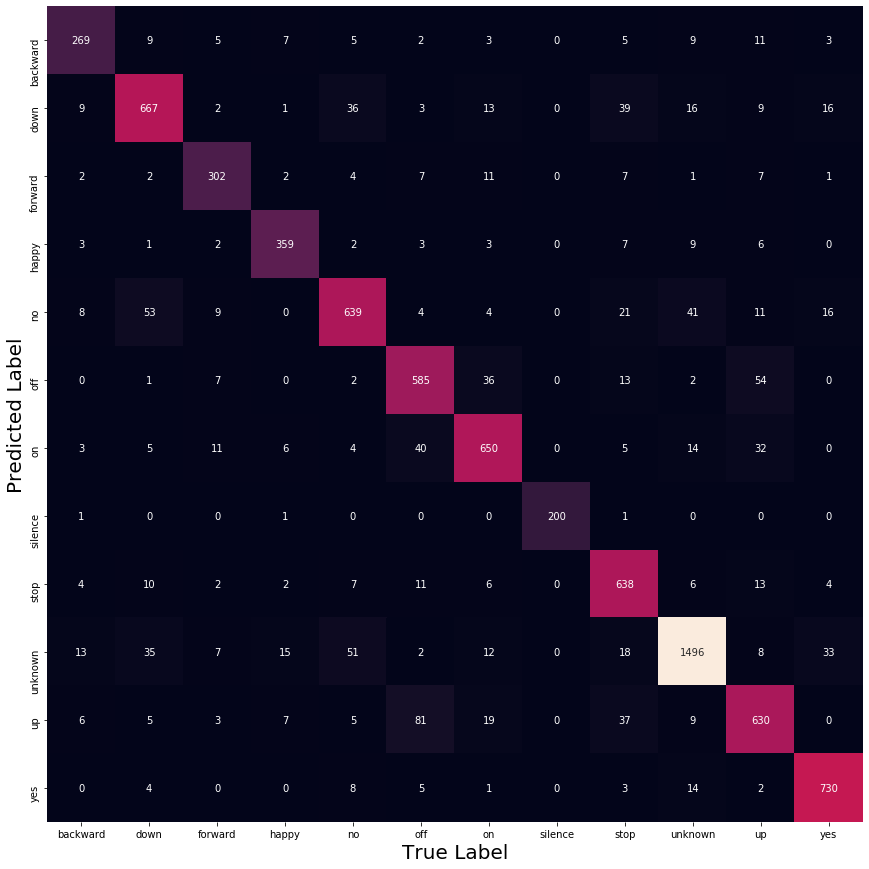

In [31]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('True Label', fontsize = 20)
plt.ylabel('Predicted Label', fontsize = 20);

### Classification Report

In [32]:

from sklearn.metrics import classification_report

y_true = y_test.argmax(axis=1)
y_pred = model.predict(x_test)

y_pred_again = []
for i in range(len(y_pred)):
    r = np.zeros(12)
    r[np.argmax(y_pred[i])] = 1
    y_pred_again.append(r)
    
yyyyy = np.array(y_pred_again)
y_pred = np.argmax(yyyyy, axis=1)
target_names = classes

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(8321,) (8321,)
              precision    recall  f1-score   support

    backward       0.82      0.85      0.83       318
        down       0.82      0.84      0.83       792
     forward       0.87      0.86      0.87       350
       happy       0.91      0.90      0.90       400
          no       0.79      0.84      0.81       763
         off       0.84      0.79      0.81       743
          on       0.84      0.86      0.85       758
     silence       0.99      1.00      0.99       200
        stop       0.91      0.80      0.85       794
     unknown       0.89      0.93      0.90      1617
          up       0.79      0.80      0.79       783
         yes       0.95      0.91      0.93       803

    accuracy                           0.86      8321
   macro avg       0.87      0.86      0.87      8321
weighted avg       0.86      0.86      0.86      8321

